# 29837043_Scenario_2

- Module Code: CSMAD21
- Assignment Report Title: Applied Data Science with Python
- Student Number: 29837043 
- Date (when the work completed): Jan 1st, 2022 
- Actual hrs spent for the assignment:  15 hrs
- Assignment evaluation (3 key points): 
    - 1. Excited to work on Python for dissertation
    - 2. Good experience to work something new that wasn't my background
    - 3. Learned a lot of concepts for the first time
                                        

### Scenario_2_Travel time to Uni_Task_1_Feasibility analysis

<span style="color:blue"><b>Importing the required libraries</b></span>

In [2]:
# Typical liubraries for data analysis [1]
%matplotlib inline
from config import *
import tweepy
import datetime
import pandas as pd
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import numpy as np
import json
import csv
import requests

##Libraries needed for training the clustering algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM

##Libraries needed for the additional functions and metrics: 
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from matplotlib.patches import Ellipse

##Needed for normalisation
from sklearn import preprocessing


<span style="color:blue"><b>Step 1A: Data extraction from the data source and Exploratory Analysis</b></span>

In [3]:
# Define the api_key and url
api_key = ''
url ='https://maps.googleapis.com/maps/api/distancematrix/json?'

In [5]:
# Downloaded the RG postcodes from the link provided in assignment
# Read the RG postcode csv file and store it in a dataframe
df = pd.read_csv('29837043_RG_postcodes.csv')

In [6]:
# Find the number of rows and columns in the dataframe
df.shape

(23396, 51)

In [7]:
# Find the column names in datafr
df.columns

Index(['Postcode', 'In Use?', 'Latitude', 'Longitude', 'Easting', 'Northing',
       'Grid Ref', 'County', 'District', 'Ward', 'District Code', 'Ward Code',
       'Country', 'County Code', 'Constituency', 'Introduced', 'Terminated',
       'Parish', 'National Park', 'Population', 'Households', 'Built up area',
       'Built up sub-division', 'Lower layer super output area', 'Rural/urban',
       'Region', 'Altitude', 'London zone', 'LSOA Code', 'Local authority',
       'MSOA Code', 'Middle layer super output area', 'Parish Code',
       'Census output area', 'Constituency Code',
       'Index of Multiple Deprivation', 'Quality', 'User Type', 'Last updated',
       'Nearest station', 'Distance to station', 'Postcode area',
       'Postcode district', 'Police force', 'Water company', 'Plus Code',
       'Average Income', 'Sewage Company', 'Travel To Work Area',
       'ITL level 2', 'ITL level 3'],
      dtype='object')

In [8]:
# EDA on full dataset taking Postcode, Latitude and Longitude
rgpostcodedf = df[['Postcode','Latitude','Longitude']]
rgpostcodedf

,Postcode,Latitude,Longitude
0,RG1 1AF,51.457494,-0.969301
1,RG1 1AR,51.457149,-0.968770
2,RG1 1AX,51.458406,-0.969741
3,RG1 1AZ,51.457575,-0.970200
4,RG1 1BU,51.457619,-0.971270
...,...,...,...
23391,RG9 9HN,51.535934,-0.904000
23392,RG9 9JE,51.535934,-0.904000
23393,RG9 9JF,51.535934,-0.904000
23394,RG9 9JL,51.535934,-0.904000


In [9]:
# Find the total number of missing values
rgpostcodedf.isnull().sum()

Postcode     0
Latitude     0
Longitude    0
dtype: int64

In [10]:
# Remove any missing values
rgpostcodedf2 = rgpostcodedf.dropna().copy()
rgpostcodedf2.isnull().sum()
rgpostcodedf2.shape

(23396, 3)

In [11]:
# Select Latitude and Longitude from rgpostcodedf2
latlongdf = rgpostcodedf2[['Latitude', 'Longitude']]

In [12]:
# Find the characteristics of the variables in latlongdf dataframe
latlongdf.describe()

,Latitude,Longitude
count,23396.000000,23396.000000
mean,51.402036,-1.032286
std,0.081874,0.183800
min,51.164036,-1.594053
25%,51.364347,-1.132570
50%,51.415054,-0.996219
75%,51.454505,-0.903335
max,51.636511,-0.699227


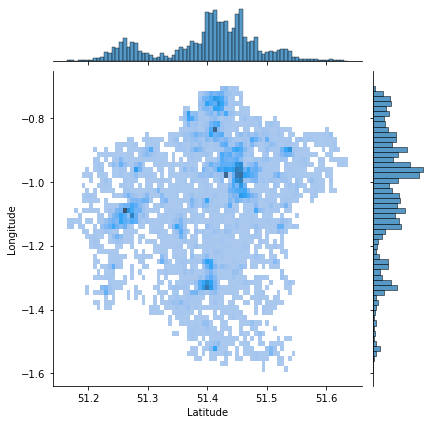

In [13]:
# Create a histogram plot with Latitude and Logitude
sns.jointplot(x='Latitude',y='Longitude',data=latlongdf, kind='hist')

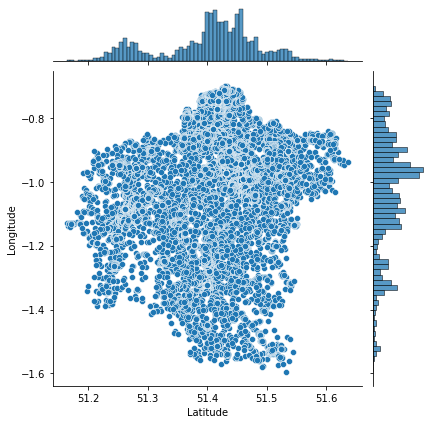

In [14]:
# Create a scatter plot with Latitude and Logitude
sns.jointplot(x='Latitude',y='Longitude',data=latlongdf, kind='scatter')

<span style="color:blue"><b>Step 1B: Perform API request to find the travel time for 5 postocdes</b></span>

In [34]:
# Defining the function to extract values from json
def json_extract(obj, key):
    # Fetch values from nested json
    arr = []

    def extract(obj, arr, key):
        # Search for values of key in json
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr, key)
                elif k == key:
                    arr.append(v)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)
        return arr

    values = extract(obj, arr, key)
    return values

In [44]:
# Selecting top 5 postcodes to get their travel time
postcode5 = rgpostcodedf2.head(5)
postcode5

,Postcode,Latitude,Longitude
0,RG1 1AF,51.457494,-0.969301
1,RG1 1AR,51.457149,-0.968770
2,RG1 1AX,51.458406,-0.969741
3,RG1 1AZ,51.457575,-0.970200
4,RG1 1BU,51.457619,-0.971270


In [46]:
# Find the json to calculate travel time using origin to destination [2]
dest = 'RG66AH'
modepublic = 'transit'    # transit mode is used to determine the travel time by public transport
modecar = 'driving'       # driving mode is used to determine the travel time by car
modewalk = 'walking'      # walking mode is used to determine the travel time by walk
deptime = 'now' 
postcode5list = []

for row in postcode5.itertuples(index=False): 
    orig, lat, long = row[:3]    

    response_car = requests.get(url + 'origins=' + orig +
                   '&destinations=' + dest +
                   '&mode=' + modecar +
                   '&departure_time=' + deptime +
                   '&key=' + api_key) 
    response_public = requests.get(url + 'origins=' + orig +
                   '&destinations=' + dest +
                   '&mode=' + modecar +
                   '&departure_time=' + deptime +
                   '&key=' + api_key) 
    response_walk = requests.get(url + 'origins=' + orig +
                   '&destinations=' + dest +
                   '&mode=' + modewalk +
                   '&departure_time=' + deptime +
                   '&key=' + api_key) 
    
    response_car.json()
    response_public.json()
    response_walk.json()
    
    textvaluescar = json_extract(response_car.json(), 'text')
    durationsbycar = textvaluescar[1::2]
    textvaluescar = json_extract(response_public.json(), 'text')
    durationsbypublic = textvaluescar[1::2]
    textvaluescar = json_extract(response_walk.json(), 'text')
    durationsbywalk = textvaluescar[1::2]
    
    
    postcdlist = {'Postcode': orig,
                  'Latitude': lat,
                  'Longitude': long,
                 'Car travel time to whiteknights': durationsbycar,
                 'Public transport time to whiteknights': durationsbypublic,
                 'Walking to whiteknights': durationsbywalk }
    
    postcode5list.append(postcdlist)


In [49]:
# Update the resultdf with all travel values
postcode5df = pd.DataFrame(postcode5list)
postcode5df

,Postcode,Latitude,Longitude,Car travel time to whiteknights,Public transport time to whiteknights,Walking to whiteknights
0,RG1 1AF,51.457494,-0.969301,[9 mins],[9 mins],[37 mins]
1,RG1 1AR,51.457149,-0.968770,[8 mins],[8 mins],[37 mins]
2,RG1 1AX,51.458406,-0.969741,[8 mins],[8 mins],[38 mins]
3,RG1 1AZ,51.457575,-0.970200,[9 mins],[9 mins],[39 mins]
4,RG1 1BU,51.457619,-0.971270,[9 mins],[9 mins],[40 mins]


In [50]:
# Remove the puchtuations from the columns [3]
string.punctuation
'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

def remove_punct(textin):
    textin  = "".join([char for char in textin if char not in string.punctuation])
    return textin

postcode5df['Car travel time to whiteknights'] = postcode5df['Car travel time to whiteknights'].apply(lambda x: remove_punct(x))
postcode5df['Public transport time to whiteknights'] = postcode5df['Public transport time to whiteknights'].apply(lambda x: remove_punct(x))
postcode5df['Walking to whiteknights'] = postcode5df['Walking to whiteknights'].apply(lambda x: remove_punct(x))


In [51]:
postcode5df

,Postcode,Latitude,Longitude,Car travel time to whiteknights,Public transport time to whiteknights,Walking to whiteknights
0,RG1 1AF,51.457494,-0.969301,9 mins,9 mins,37 mins
1,RG1 1AR,51.457149,-0.968770,8 mins,8 mins,37 mins
2,RG1 1AX,51.458406,-0.969741,8 mins,8 mins,38 mins
3,RG1 1AZ,51.457575,-0.970200,9 mins,9 mins,39 mins
4,RG1 1BU,51.457619,-0.971270,9 mins,9 mins,40 mins


### Scenario_2_Travel time to Uni_Task_2_Data Extraction Strategy

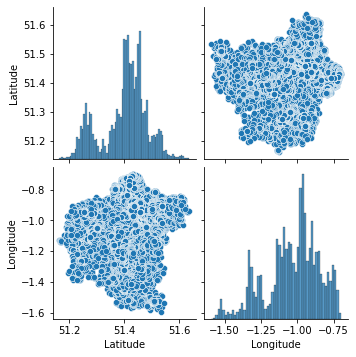

In [15]:
# Find the distribution of the latitude and longitude
sns.pairplot(latlongdf)

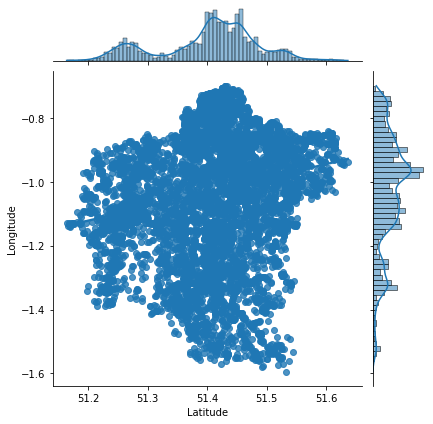

In [16]:
sns.jointplot(x='Latitude',y='Longitude',data=latlongdf, kind='reg')

<span style="color:blue"><b>Step A: Applying KMeans clustering</b></span> 

In [17]:
##Creating a method to visualise the centroids area of influence

def plot_kmeans(kmeans, X, n_clusters=2, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

In [18]:
# Defining the clusters to analyse 
c_num = 5 

#Creating the deffinition of the models
km_latlong = KMeans(n_clusters=c_num)

#Training the model to a particular dataset
km_latlong.fit(latlongdf[['Latitude','Longitude']])

#Predicting the "labels" with the model defined and trained before
y_km_latlong = km_latlong.predict(latlongdf[['Latitude','Longitude']])


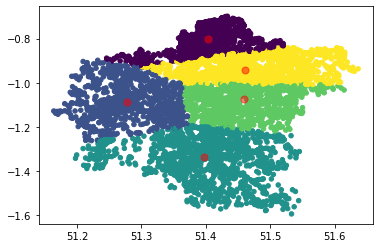

In [19]:
# Plot the scatter plot for KMeans
plt.scatter(x='Latitude', y='Longitude', data=latlongdf, c=y_km_latlong, s=20, cmap='viridis');
centers = km_latlong.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.5);

In [20]:
# The latitude and logitude of centroids
centers

array([[51.40413512, -0.80216232],
       [51.27726211, -1.08697028],
       [51.39662055, -1.33656894],
       [51.4585428 , -1.07298011],
       [51.46081349, -0.94122499]])

In [21]:
# Convert Centroids to dataframe
centroids = np.array(centers)
centroidsdf = pd.DataFrame({'Latitude': centroids[:, 0], 'Longitude': centroids[:, 1]})
centroidsdf

,Latitude,Longitude
0,51.404135,-0.802162
1,51.277262,-1.086970
2,51.396621,-1.336569
3,51.458543,-1.072980
4,51.460813,-0.941225


<span style="color:blue"><b>Step B: Identify the ideal number of cluster selection for K-means</b></span> 

In [22]:
# List to store the metric value given different K values
inertia = []
#Range of the different values of K to analyse
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(latlongdf[['Latitude','Longitude']])
    inertia.append(km.inertia_)

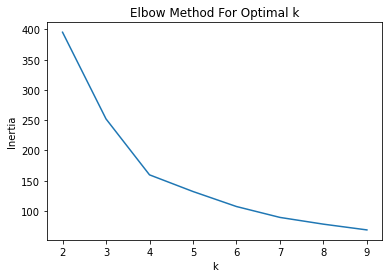

In [23]:
# Plot the Elbow method
plt.plot(K, inertia)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [24]:
# Import the library to calculate the silhouette score for KMeans

## List to store the metric value given different K values
s_score = []
# Range of the different values of K to analyse
K = range(2,10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(latlongdf)
    s_score.append(silhouette_score(latlongdf[['Latitude','Longitude']], kmeans.labels_))

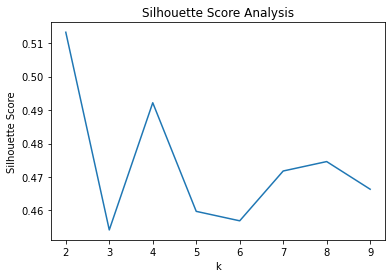

In [25]:
# Plotting the values of the metric
plt.plot(K, s_score)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Analysis')
plt.show()

In [26]:
X = latlongdf.values
X = X[:, ::-1] # flip axes for better plotting

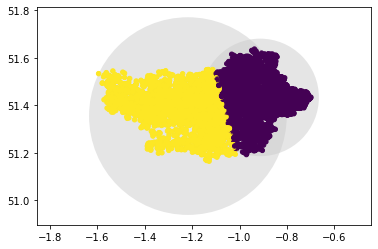

In [27]:
kmeans = KMeans(n_clusters=2, random_state=0)
plot_kmeans(kmeans, X)

<span style="color:blue"><b>Step C: Find the travel time for postcodes that are closest to centroids</b></span>

In [28]:
rgpostcodedf.shape

(23396, 3)

In [29]:
centroidsdf

,Latitude,Longitude
0,51.404135,-0.802162
1,51.277262,-1.086970
2,51.396621,-1.336569
3,51.458543,-1.072980
4,51.460813,-0.941225


In [30]:
rgpostcodedf2 = rgpostcodedf[['Postcode','Latitude','Longitude']]

In [31]:
# Find the closest Postcodes [4]
closestdf1 = pd.DataFrame(columns=['Postcode', 'Latitude', 'Longitude'])

for eachlat in centroidsdf['Latitude']:
    i = (rgpostcodedf2["Latitude"]-eachlat).abs().argsort()[:1]
    closestdf1 = closestdf1.append(rgpostcodedf2.loc[i])
    

In [54]:
closestdf1

,Postcode,Latitude,Longitude
20245,RG7 1WJ,51.404132,-0.979141
9897,RG24 7AZ,51.277257,-1.017181
20030,RG7 1FL,51.396620,-0.962110
19044,RG5 4NP,51.458544,-0.899756
7457,RG20 8JD,51.460815,-1.427565


In [55]:
# Define a empty dataframe
resultdf = pd.DataFrame(columns=['Postcode', 'Car travel time to whiteknights', 
                                 'Public transport time to whiteknights', 'Walking to whiteknights'])

In [56]:
# Find the json to calculate travel time in later stage using origin to destination [2]
dest = 'RG66AH'
modepublic = 'transit'    # transit mode is used to determine the travel time by public transport
modecar = 'driving'       # driving mode is used to determine the travel time by car
modewalk = 'walking'      # walking mode is used to determine the travel time by walk
deptime = 'now' 
resultlist = []

for row in closestdf1.itertuples(index=False): 
    orig, lat, long = row[:3]    

    response_car = requests.get(url + 'origins=' + orig +
                   '&destinations=' + dest +
                   '&mode=' + modecar +
                   '&departure_time=' + deptime +
                   '&key=' + api_key) 
    response_public = requests.get(url + 'origins=' + orig +
                   '&destinations=' + dest +
                   '&mode=' + modecar +
                   '&departure_time=' + deptime +
                   '&key=' + api_key) 
    response_walk = requests.get(url + 'origins=' + orig +
                   '&destinations=' + dest +
                   '&mode=' + modewalk +
                   '&departure_time=' + deptime +
                   '&key=' + api_key) 
    
    response_car.json()
    response_public.json()
    response_walk.json()
    
    textvaluescar = json_extract(response_car.json(), 'text')
    durationsbycar = textvaluescar[1::2]
    textvaluescar = json_extract(response_public.json(), 'text')
    durationsbypublic = textvaluescar[1::2]
    textvaluescar = json_extract(response_walk.json(), 'text')
    durationsbywalk = textvaluescar[1::2]
    
    
    travellist = {'Postcode': orig,
                  'Latitude': lat,
                  'Longitude': long,
                 'Car travel time to whiteknights': durationsbycar,
                 'Public transport time to whiteknights': durationsbypublic,
                 'Walking to whiteknights': durationsbywalk }
    
    resultlist.append(travellist)


In [57]:
# Update the resultdf with all travel values
resultdf = pd.DataFrame(resultlist)

In [58]:
# Remove the puchtuations from the columns
resultdf['Car travel time to whiteknights'] = resultdf['Car travel time to whiteknights'].apply(lambda x: remove_punct(x))
resultdf['Public transport time to whiteknights'] = resultdf['Public transport time to whiteknights'].apply(lambda x: remove_punct(x))
resultdf['Walking to whiteknights'] = resultdf['Walking to whiteknights'].apply(lambda x: remove_punct(x))



In [59]:
resultdf

,Postcode,Latitude,Longitude,Car travel time to whiteknights,Public transport time to whiteknights,Walking to whiteknights
0,RG7 1WJ,51.404132,-0.979141,19 mins,19 mins,1 hour 46 mins
1,RG24 7AZ,51.277257,-1.017181,39 mins,39 mins,5 hours 33 mins
2,RG7 1FL,51.396620,-0.962110,20 mins,20 mins,1 hour 50 mins
3,RG5 4NP,51.458544,-0.899756,6 mins,6 mins,44 mins
4,RG20 8JD,51.460815,-1.427565,42 mins,42 mins,8 hours 18 mins


In [60]:
# Creating a new Dataframe as per the requirement
task2df = resultdf[['Postcode','Car travel time to whiteknights',
                'Public transport time to whiteknights','Walking to whiteknights']]
task2df

,Postcode,Car travel time to whiteknights,Public transport time to whiteknights,Walking to whiteknights
0,RG7 1WJ,19 mins,19 mins,1 hour 46 mins
1,RG24 7AZ,39 mins,39 mins,5 hours 33 mins
2,RG7 1FL,20 mins,20 mins,1 hour 50 mins
3,RG5 4NP,6 mins,6 mins,44 mins
4,RG20 8JD,42 mins,42 mins,8 hours 18 mins


In [61]:
# Save the dataframe into excel sheet
task2df.to_excel("29837043_S2T2_RG.xlsx", index = True)

### Scenario_2_Travel time to Uni_Task_3_Solution implementation

In [62]:
rgpostcodedf

,Postcode,Latitude,Longitude,Car travel time to whiteknights,Public transport time to whiteknights,Walking to whiteknights
0,RG1 1AF,51.457494,-0.969301,[6 mins],[6 mins],[44 mins]
1,RG1 1AR,51.457149,-0.968770,6 mins,6 mins,44 mins
2,RG1 1AX,51.458406,-0.969741,6 mins,6 mins,44 mins
3,RG1 1AZ,51.457575,-0.970200,6 mins,6 mins,44 mins
4,RG1 1BU,51.457619,-0.971270,6 mins,6 mins,44 mins
...,...,...,...,...,...,...
23391,RG9 9HN,51.535934,-0.904000,42 mins,42 mins,8 hours 18 mins
23392,RG9 9JE,51.535934,-0.904000,42 mins,42 mins,8 hours 18 mins
23393,RG9 9JF,51.535934,-0.904000,42 mins,42 mins,8 hours 18 mins
23394,RG9 9JL,51.535934,-0.904000,42 mins,42 mins,8 hours 18 mins


In [63]:
# Find the json values to calculate travel time in later stage using origin to destination
dest = 'RG66AH'
modepublic = 'transit'    # transit mode is used to determine the travel time by public transport
modecar = 'driving'       # driving mode is used to determine the travel time by car
modewalk = 'walking'      # walking mode is used to determine the travel time by walk
deptime = 'now' 

for row in rgpostcodedf.itertuples(index=True): 
    index, orig, lat, long = row[:4]
    
    # Find the closest Latitude and get the index value
    ind = (resultdf['Latitude']-lat).abs().argsort()[:1] 
    
    # Get the travel time of Car, Public and Walk from respective columns
    car = resultdf.loc[ind,'Car travel time to whiteknights']
    public = resultdf.loc[ind,'Public transport time to whiteknights']
    walk = resultdf.loc[ind,'Walking to whiteknights']
    
    # Retrieve the value from the series
    cartime = pd.Series(car).values
    publictime = pd.Series(public).values
    walktime = pd.Series(walk).values
    
    # Set the travel time values for all 23K+ Postcodes with their respective values
    rgpostcodedf.loc[index,'Car travel time to whiteknights'] = cartime
    rgpostcodedf.loc[index,'Public transport time to whiteknights'] = publictime
    rgpostcodedf.loc[index,'Walking to whiteknights'] = walktime

rgpostcodedf

/Users/aditidadariya/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1797: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


,Postcode,Latitude,Longitude,Car travel time to whiteknights,Public transport time to whiteknights,Walking to whiteknights
0,RG1 1AF,51.457494,-0.969301,6 mins,6 mins,44 mins
1,RG1 1AR,51.457149,-0.968770,6 mins,6 mins,44 mins
2,RG1 1AX,51.458406,-0.969741,6 mins,6 mins,44 mins
3,RG1 1AZ,51.457575,-0.970200,6 mins,6 mins,44 mins
4,RG1 1BU,51.457619,-0.971270,6 mins,6 mins,44 mins
...,...,...,...,...,...,...
23391,RG9 9HN,51.535934,-0.904000,42 mins,42 mins,8 hours 18 mins
23392,RG9 9JE,51.535934,-0.904000,42 mins,42 mins,8 hours 18 mins
23393,RG9 9JF,51.535934,-0.904000,42 mins,42 mins,8 hours 18 mins
23394,RG9 9JL,51.535934,-0.904000,42 mins,42 mins,8 hours 18 mins


In [64]:
# Creating a new Dataframe as per the requirement
task3df = rgpostcodedf[['Postcode','Car travel time to whiteknights',
                'Public transport time to whiteknights','Walking to whiteknights']]
task3df

,Postcode,Car travel time to whiteknights,Public transport time to whiteknights,Walking to whiteknights
0,RG1 1AF,6 mins,6 mins,44 mins
1,RG1 1AR,6 mins,6 mins,44 mins
2,RG1 1AX,6 mins,6 mins,44 mins
3,RG1 1AZ,6 mins,6 mins,44 mins
4,RG1 1BU,6 mins,6 mins,44 mins
...,...,...,...,...
23391,RG9 9HN,42 mins,42 mins,8 hours 18 mins
23392,RG9 9JE,42 mins,42 mins,8 hours 18 mins
23393,RG9 9JF,42 mins,42 mins,8 hours 18 mins
23394,RG9 9JL,42 mins,42 mins,8 hours 18 mins


In [65]:
# Save the dataframe into excel sheet
task3df.to_excel("29837043_S2T3_RG.xlsx", index = True)

### References:
- [1] https://docs.tweepy.org/en/stable/install.html
- [2] https://developers.google.com/maps/documentation/distance-matrix/overview#maps_http_distancematrix_encoded-py
- [3] https://www.kaggle.com/ragnisah/text-data-cleaning-tweets-analysis
- [4] https://codereview.stackexchange.com/questions/204549/lookup-closest-value-in-pandas-dataframe